# SmartBin-AI powered waste Classification (Week 1)

**PROBLEM STATEMENT**:

“Improper waste segregation leads to pollution and wasted resources. This project uses AI to automatically classify waste into 7 categories, enabling faster, accurate recycling and promoting a cleaner, sustainable environment.”

## Step 1: Import Libraries

We start by importing the basic Python libraries:
- **pandas**: for handling structured data
- **numpy**: for numerical operations


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"fathimathrizwana","key":"d703c708db3742f64e21f5979cea4297"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [ ]:
!pip install kaggle

## Step 2: Load Dataset

The dataset is downloaded from Kaggle (Multi-class Garbage Classification).  
It contains images of **7 waste categories** stored in folders.


In [ ]:
!kaggle datasets download -d vishallazrus/multi-class-garbage-classification-dataset


Dataset URL: https://www.kaggle.com/datasets/vishallazrus/multi-class-garbage-classification-dataset
License(s): apache-2.0
  0% 0.00/29.2M [00:00<?, ?B/s]
100% 29.2M/29.2M [00:00<00:00, 860MB/s]


In [ ]:
import zipfile
import os

with zipfile.ZipFile("multi-class-garbage-classification-dataset.zip", "r") as zip_ref:
    zip_ref.extractall("waste_data")

os.listdir("waste_data")



['Multi class garbage classification']

In [ ]:
os.listdir("waste_data/Multi class garbage classification")


['train', 'test', 'labels.txt']

In [ ]:
# Look inside the train folder
train_path = "waste_data/Multi class garbage classification/train"

for folder in os.listdir(train_path):
    count = len(os.listdir(os.path.join(train_path, folder)))
    print(folder, ":", count, "images")


paper : 554 images
trash : 141 images
glass : 461 images
metal : 370 images
plastic : 438 images
compost : 139 images
cardboard : 363 images


## Step 3: Explore Dataset

Before training any model, we need to understand the dataset.  
We will:
- Check total number of images
- See distribution of classes
- Look for missing values
- View a random sample image


In [ ]:
import pandas as pd

data = []

for folder in os.listdir(train_path):
    for file in os.listdir(os.path.join(train_path, folder)):
        data.append([file, folder])

df = pd.DataFrame(data, columns=["filename", "class"])

# Now explore
print(df.info())
print(df.describe())
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2466 entries, 0 to 2465
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  2466 non-null   object
 1   class     2466 non-null   object
dtypes: object(2)
memory usage: 38.7+ KB
None
                filename  class
count               2466   2466
unique              2466      7
top     cardboard229.jpg  paper
freq                   1    554
filename    0
class       0
dtype: int64


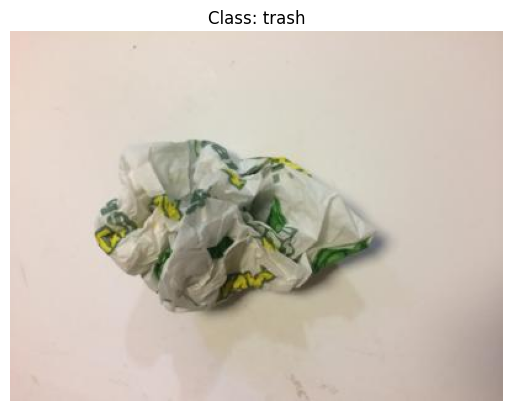

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

# Pick a random class
sample_class = random.choice(os.listdir(train_path))

# Pick a random image from that class
sample_image = random.choice(os.listdir(os.path.join(train_path, sample_class)))

# Load and show
img_path = os.path.join(train_path, sample_class, sample_image)
img = mpimg.imread(img_path)

plt.imshow(img)
plt.title(f"Class: {sample_class}")
plt.axis("off")
plt.show()


# SmartBin-AI powered waste Classification (Week 2)

**FOCUS**:  
In this week, we move from dataset preparation to **training and testing models**.  
The goal is to build an efficient AI model that can classify waste into 7 categories with good accuracy.






In [ ]:
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [ ]:
train_dir = "waste_data/Multi class garbage classification/train"
test_dir = "waste_data/Multi class garbage classification/test"

# quick check
print("Train folder contains:", os.listdir(train_dir))
print("Test folder contains:", os.listdir(test_dir))


Train folder contains: ['paper', 'trash', 'glass', 'metal', 'plastic', 'compost', 'cardboard']
Test folder contains: ['paper', 'trash', 'glass', 'metal', 'plastic', 'compost', 'cardboard']


## Step 4: Data Preprocessing
We prepare the dataset before training:
- Normalize pixel values (0–1 range)  
- Resize all images to a uniform shape  
- Split dataset into **train, validation, and test sets**

In [ ]:
# Data augmentation for training set
train_datagen = ImageDataGenerator(
    rescale=1./255,          # Normalize pixels
    validation_split=0.2,    # Split 20% for validation
    rotation_range=20,        # Random rotations
    width_shift_range=0.2,    # Horizontal shift
    height_shift_range=0.2,   # Vertical shift
    shear_range=0.2,          # Shear
    zoom_range=0.2,           # Zoom
    horizontal_flip=True       # Flip
)

# No augmentation for validation/test, only normalization
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)


In [ ]:
img_height, img_width = 224, 224  #
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # multi-class
    subset='training'           # training data
)

validation_generator = test_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',  # multi-class
    subset='validation'         # validation data
)


Found 1976 images belonging to 7 classes.
Found 490 images belonging to 7 classes.


In [ ]:
print("Classes:", train_generator.class_indices)
print("Number of training samples:", train_generator.samples)
print("Number of validation samples:", validation_generator.samples)


Classes: {'cardboard': 0, 'compost': 1, 'glass': 2, 'metal': 3, 'paper': 4, 'plastic': 5, 'trash': 6}
Number of training samples: 1976
Number of validation samples: 490


## Step 5: Build Model (Transfer Learning)
We use **MobileNetV2** (pre-trained on ImageNet) and adapt it for our 7 waste categories.  
- Load MobileNetV2 as the base model  
- Freeze base layers to retain learned features  
- Add custom classification layers on top  
- Final layer uses **Softmax** for 7 outputs
## Step 6: Train Model
We train the model on the training dataset.  
- Use an optimizer (Adam)  
- Monitor **loss** and **accuracy** on validation data  
- Apply **early stopping** to avoid overfitting

In [ ]:
# -----------------------------
# Step: MobileNetV2 Transfer Learning
# -----------------------------
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

num_classes = 7  # 7 waste categories
img_height, img_width = 224, 224  # MobileNetV2 requires >=224

# Load pre-trained MobileNetV2 without top layers
base_model = MobileNetV2(weights='imagenet', include_top=False,
                         input_shape=(img_height, img_width, 3))
base_model.trainable = False  # Freeze base layers

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

# Define final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
epochs = 10  # start small, increase later if needed
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs
)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.2478 - loss: 2.0120 - val_accuracy: 0.4980 - val_loss: 1.4383
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.4833 - loss: 1.4287 - val_accuracy: 0.5857 - val_loss: 1.1831
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.5513 - loss: 1.2192 - val_accuracy: 0.6367 - val_loss: 1.0275
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.6207 - loss: 1.0674 - val_accuracy: 0.6449 - val_loss: 0.9503
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.6449 - loss: 0.9734 - val_accuracy: 0.6796 - val_loss: 0.8869
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.6776 - loss: 0.9024 - val_accuracy: 0.6939 - val_loss: 0.8501
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.6884 - loss: 0.8345 - val_accuracy: 0.7020 - val_loss: 0.8158
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.7091 - loss: 0.8084 - val_accuracy: 0.7102 - v

## Step 7: Evaluate Model
We test the trained MobileNetV2 on unseen data.  


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing import image


In [ ]:
def predict_waste(img_path, model, target_size=(224,224)):
    # Load the image
    img = image.load_img(img_path, target_size=target_size)
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # batch dimension
    img_array /= 255.0  # normalize

    # Predict
    pred = model.predict(img_array)
    class_index = np.argmax(pred)

    # Map index to class name
    class_labels = {v: k for k, v in train_generator.class_indices.items()}
    predicted_class = class_labels[class_index]

    return predicted_class, pred[0][class_index]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Actual class: compost
Predicted class: compost (confidence: 0.62)


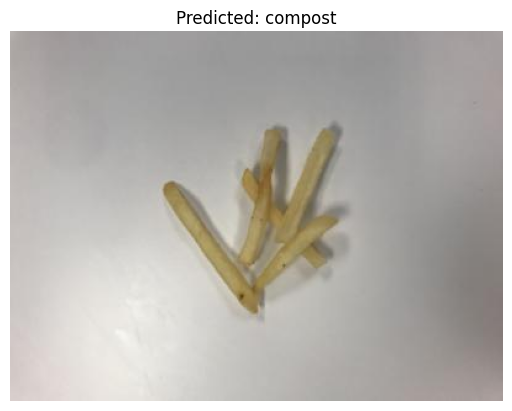

In [ ]:
# Pick a random image from test folder
import random
test_class = random.choice(os.listdir(test_dir))
test_image = random.choice(os.listdir(os.path.join(test_dir, test_class)))
img_path = os.path.join(test_dir, test_class, test_image)

pred_class, confidence = predict_waste(img_path, model)
print(f"Actual class: {test_class}")
print(f"Predicted class: {pred_class} (confidence: {confidence:.2f})")

# Display image
import matplotlib.pyplot as plt
img = plt.imread(img_path)
plt.imshow(img)
plt.title(f"Predicted: {pred_class}")
plt.axis("off")
plt.show()


In [ ]:
from google.colab import files

uploaded = files.upload()  # you can select multiple files at once


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for filename in uploaded.keys():
    img_path = filename
    pred_class, class_conf = predict_waste(img_path, model)  # your existing 7-class function

    print(f"File: {filename}")
    print(f"Predicted class: {pred_class} (Confidence: {class_conf:.2f})")

    # Display the image
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(f"Predicted: {pred_class}")
    plt.axis("off")
    plt.show()

